In [1]:
from functools import partial
from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import dimensionless, galactic, UnitSystem
import time

import jax
import jax.numpy as jnp

from jax.config import config
config.update("jax_enable_x64", True)


import jax.random as random 
from matplotlib.patches import Ellipse
import jax.scipy.stats as statsjax

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt,PIDController,DiscreteTerminatingEvent, DirectAdjoint, RecursiveCheckpointAdjoint

import JaxStreams


/tmp/ipykernel_521391/3400544145.py:20: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import sys, importlib
importlib.reload(JaxStreams)

gpu


<module 'JaxStreams' from '/scratch/gpfs/jn5830/JaxStreamsShare/JaxStreams.py'>

## Internal units are kpc, kpc/Myr, Myr, Msun (i.e., G \neq 1)


In [3]:
# Setting up a global potential
params_global_potential = {'m_disk':5.0e10, 'a_disk': 3.0, 'b_disk': 0.25, 'm_NFW': 1.0e12,
                          'r_s_NFW': 15.0}

pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params_global_potential['m_disk'], a=params_global_potential['a_disk'],
                                       b=params_global_potential['b_disk'],units=usys)
pot_NFW = JaxStreams.NFWPotential(m=params_global_potential['m_NFW'], r_s=params_global_potential['r_s_NFW'],units=usys)

## Combine potentials in a list structure
potential_list = [pot_disk,pot_NFW]
pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)




In [4]:
pot.gradient(jnp.array([1.,2,3]),10.0)

Array([0.00283263, 0.00566527, 0.01104766], dtype=float64)

In [5]:
# Present day location of pal 5 progenitor
pal5_c = coord.SkyCoord(ra=229.018*u.degree, dec=-0.124*u.degree,
                         distance=22.9*u.kpc,
                         pm_ra_cosdec=-2.296*u.mas/u.yr,
                         pm_dec=-2.257*u.mas/u.yr,
                         radial_velocity=-58.7*u.km/u.s)
rep = pal5_c.transform_to(coord.Galactocentric).data
pal5_w0 = gd.PhaseSpacePosition(rep)

# current (and final) position of pal5 progenitor in a jax array
wf = jnp.hstack([pal5_w0.pos.xyz.T.value,pal5_w0.vel.d_xyz.to(u.kpc/u.Myr).value])

In [6]:
wf

Array([ 7.86771862e+00,  2.32269577e-01,  1.64124381e+01, -4.32708085e-02,
       -1.06060675e-01, -1.57716157e-02], dtype=float64)

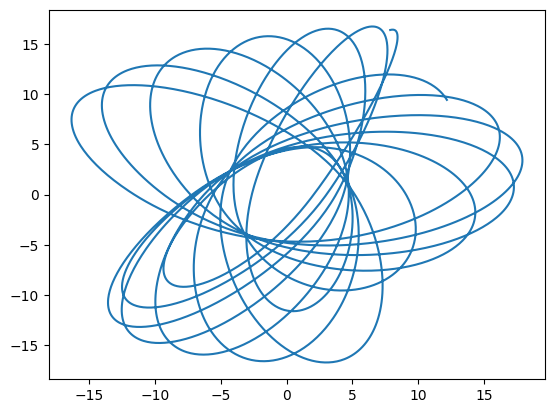

In [7]:
# let's integrate an orbit. First we will integrate backwards for 4000 Myr
t0 = 0.
dt = .5
n_steps = 4_000 #this is really how many particles you will have in one arm of the stream
tstore = jnp.linspace(0,4000.,n_steps)

## here's how you integrate an orbit, storing the positions of the orbit at t_back
t_back = -tstore
w_back = pot.orbit_integrator_run(wf,t0=0.0,t1=t_back.min(),ts=t_back)[:-1,:]

plt.plot(w_back[:,0],w_back[:,2])

A few points:
1. JaxStreams is gpu optimized, not cpu optimized.
2. Functions are jit compiled, meaning the first run of a function will be slow. Subsequent runs will be fast. One should be able to generate a 10,000 particle stream in ~2seconds.
3. The real power of the code, for sampling, is using vmap to vectorize the simulation set.

In [9]:
# Now generate a mock stream along the above orbit
M_sat = 2.5e4 #progenitor mass
seed_num=4843
t_strip = jnp.linspace(-4000,0,10_000)
start = time.time()
lead_arm, trail_arm = pot.gen_stream_vmapped(t_strip, w_back[-1], M_sat,seed_num)
end = time.time()
print('time:'+str(end-start))

time:2.647554874420166


In [10]:
stream = jnp.vstack([lead_arm,trail_arm])

In [11]:
stream.shape

(19998, 6)

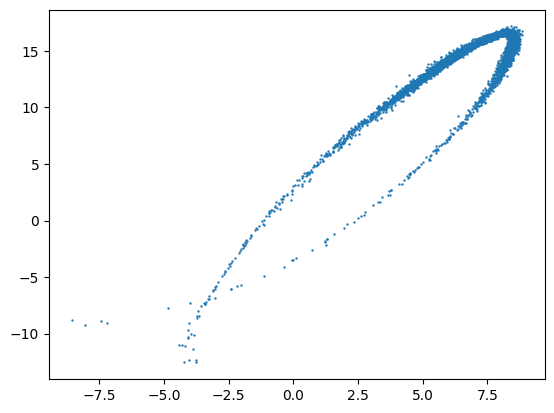

In [12]:
plt.scatter(stream[:,0],stream[:,2],s=.5)

In [13]:
def func(x):
    return x**2

In [14]:
x = jnp.linspace(0,10,50)
vmapped_func = jax.vmap(func)

In [15]:
@jax.jit
def simulator(mdisk):
    """
    this function assumes that mdisk is length 1
    """
    params_global_potential = {'m_disk':mdisk, 'a_disk': 3.0, 'b_disk': 0.25, 'm_NFW': 1.0e12,
                          'r_s_NFW': 15.0}

    pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params_global_potential['m_disk'], a=params_global_potential['a_disk'],
                                           b=params_global_potential['b_disk'],units=usys)
    pot_NFW = JaxStreams.NFWPotential(m=params_global_potential['m_NFW'], r_s=params_global_potential['r_s_NFW'],units=usys)

    ## Combine potentials in a list structure
    potential_list = [pot_disk,pot_NFW]
    pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)
    lead_arm, trail_arm = pot.gen_stream_vmapped(t_strip, w_back[-1], M_sat,seed_num)
    return jnp.vstack([lead_arm,trail_arm])
        
    

In [19]:
mass_disk_arr = jnp.linspace(1e10,8e10,80)
vmapped_sim = jax.vmap(simulator)
simulations = vmapped_sim(mass_disk_arr)
#out = simulator(5e10)

In [20]:
simulations.shape

(80, 19998, 6)

In [21]:
s = time.time()
simulations = vmapped_sim(mass_disk_arr)
e = time.time()
print(e-s)

29.806116104125977
